# **CSC2515: Introduction to Machine Learning**
# Final Project : Heart Stroke Prediction
----

## Group members:

Name | Student ID | E-mail 
--- | --- | --- 
Xiule Fan|1002108355  |  xiule.fan@mail.utoronto.ca
Bhagyashree Keswani| 1006790849 | bhagyashree.keswani@mail.utoronto.ca 
Nigel Petersen | 1005263028 | nigel.petersen@mail.utoronto.ca
Dhavalkumar Patel | 1007542777 |dhaval.patel@mail.utoronto.ca


**Pls note:**

**The dataset is uploaded from the github link so we have not provided it separately in the submission.**

**The below file may take upto 30 min to 1 hour to run completely as it involves hyperparameter tuning, neural networks and training autoencoders.**



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report,precision_score,recall_score,accuracy_score,balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample, shuffle

np.random.seed(0)
import warnings
warnings.filterwarnings(action='ignore')

# Dataset

**Pls note: The dataset is loaded from the available github link. Hence, we have not provided it separately in submission.**

In [ ]:
data_df = pd.read_csv("https://raw.githubusercontent.com/NigelPetersen/CSC2515-data/main/train_strokes.csv")

In [ ]:
data_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [ ]:
#droped nan rows
stroke_data = data_df.dropna()

# Exploratory Data Analysis

In [ ]:
# drop the id column
stroke_data = stroke_data.drop("id", axis=1)
cts_features = ["age", "avg_glucose_level", "bmi", "stroke"]
cat_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", 
                "smoking_status", "stroke"]

In [ ]:
# summary stats for continuous covariates
stroke_data[cts_features[:-1]].describe()

,age,avg_glucose_level,bmi
count,29072.000000,29072.000000,29072.000000
mean,47.671746,106.403225,30.054166
std,18.734490,45.268512,7.193908
min,10.000000,55.010000,10.100000
25%,32.000000,77.627500,25.000000
50%,48.000000,92.130000,28.900000
75%,62.000000,113.910000,33.900000
max,82.000000,291.050000,92.000000


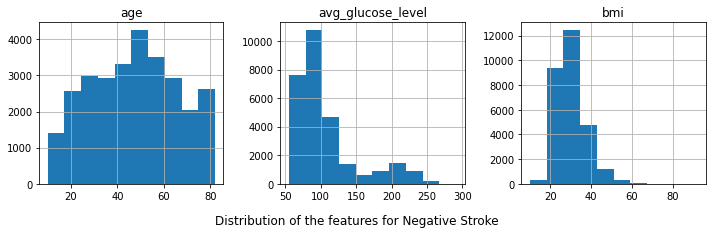

In [ ]:
# histograms for cts covarites for each value of the response
fig, axs = plt.subplots(1,3, figsize=(10,3))
for i in range(3):
    pd.DataFrame(stroke_data.loc[stroke_data["stroke"]==0, cts_features[i]]).hist(ax=axs[i])
fig.suptitle("Distribution of the features for Negative Stroke",y=-0.01)
plt.tight_layout()
plt.show()

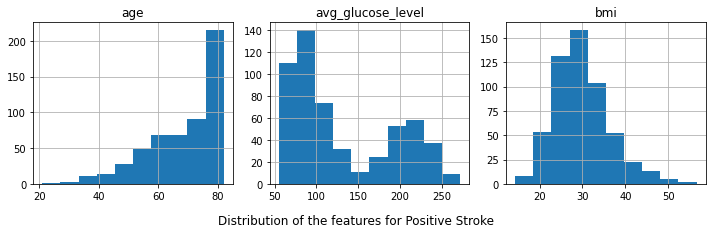

In [ ]:
# histograms for cts covarites for each value of the response
fig, axs = plt.subplots(1,3, figsize=(10,3))
for i in range(3):
    pd.DataFrame(stroke_data.loc[stroke_data["stroke"]==1, cts_features[i]]).hist(ax=axs[i])
fig.suptitle("Distribution of the features for Positive Stroke",y=-0.01)
plt.tight_layout()
plt.show()

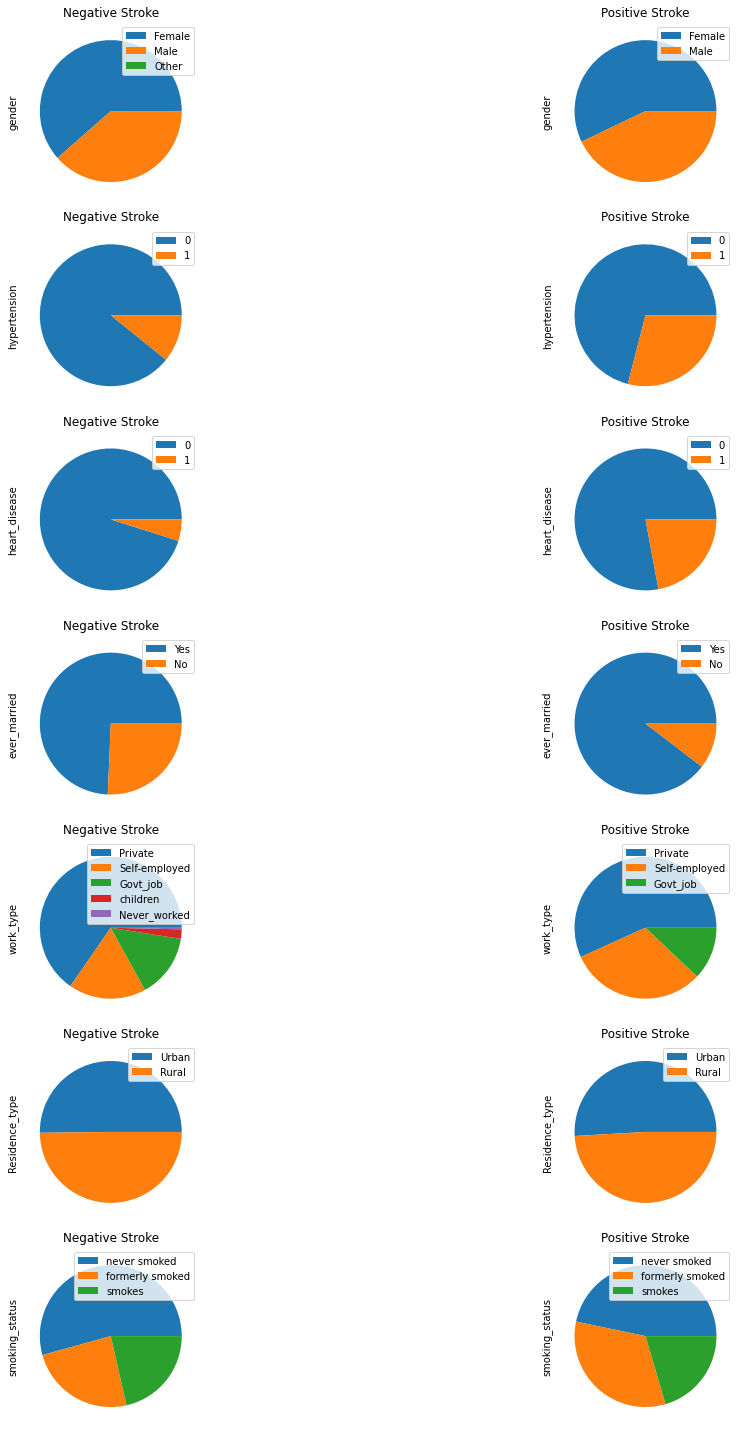

In [ ]:
# prelimnary plots for categorical features
fig, axs = plt.subplots(7,2, figsize=(20,20))
for i in range(7):
    pd.DataFrame(stroke_data.loc[stroke_data["stroke"] == 0, 
    cat_features[i]].value_counts()).plot.pie(y=cat_features[i], labels=None, ax=axs[i,0], title="Negative Stroke")
    pd.DataFrame(stroke_data.loc[stroke_data["stroke"] == 1, 
    cat_features[i]].value_counts()).plot.pie(y=cat_features[i], labels=None, ax=axs[i,1], title="Positive Stroke")
plt.tight_layout()
plt.show()

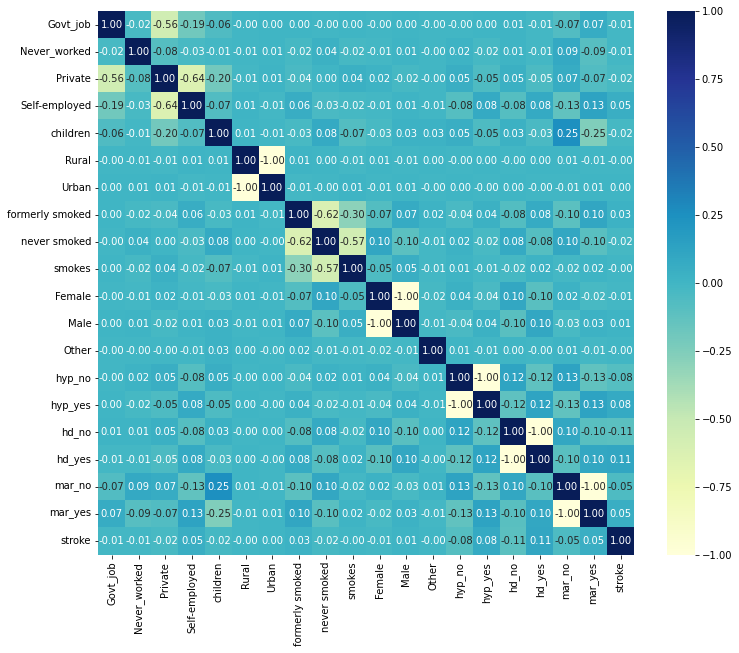

In [ ]:
hyp_dummies = pd.get_dummies(stroke_data["hypertension"])
hyp_dummies = hyp_dummies.rename({0: "hyp_no", 1:"hyp_yes"}, axis=1)

hd_dummies = pd.get_dummies(stroke_data["heart_disease"])
hd_dummies = hd_dummies.rename({0: "hd_no", 1:"hd_yes"}, axis=1)

mar_dummies = pd.get_dummies(stroke_data["ever_married"])
mar_dummies = mar_dummies.rename({"No": "mar_no", "Yes":"mar_yes"}, axis=1)

L = [pd.get_dummies(stroke_data[feature]) for feature in cat_features[4:-1]]
L.extend([pd.get_dummies(stroke_data["gender"]), hyp_dummies, hd_dummies, mar_dummies, stroke_data["stroke"]])
counts_df = pd.concat(L, axis=1)

fig1 = plt.figure(figsize=(12,10))
sns.heatmap(counts_df.corr(),annot=True,fmt='.2f', cmap="YlGnBu") 
plt.show()
# none of the levels of the categorical features have a high correlation with the response

# Feature Engineering

This dataset contains both the numerical and categorical values. 




In [ ]:
data_numeric = stroke_data[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']].reset_index(drop=True)
data_categorical = stroke_data[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']].reset_index(drop=True)

In [ ]:
# Two values
print('Marital Status:' , stroke_data['ever_married'].unique())
print('Residence Type:', stroke_data['Residence_type'].unique())

#Multiple Values
print('Gender:', stroke_data['gender'].unique())
print('Work Type:', stroke_data['work_type'].unique())
print('Smoking Status:', stroke_data['smoking_status'].unique())

Marital Status: ['Yes' 'No']
Residence Type: ['Urban' 'Rural']
Gender: ['Male' 'Female' 'Other']
Work Type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Smoking Status: ['never smoked' 'formerly smoked' 'smokes']


Label-Encoding
Columns: 'ever_married', 'Residence_type'

In [ ]:
encoder_married = LabelEncoder()
encoded_married_df = pd.DataFrame(encoder_married.fit_transform(data_categorical['ever_married']), columns=['ever_married'])

encoder_residence = LabelEncoder()
encoded_residence_df = pd.DataFrame(encoder_residence.fit_transform(data_categorical['Residence_type']), columns=['Residence_type'])


One-Hot Encoding: 

In [ ]:
encoder_gender = OneHotEncoder()
encoded_gender_df = pd.DataFrame(encoder_gender.fit_transform(np.array(data_categorical['gender']).reshape(-1,1)).toarray(), 
                                 columns=np.array(encoder_gender.categories_).tolist()[0])

encoder_smoke = OneHotEncoder()
encoded_smoke_df = pd.DataFrame(encoder_smoke.fit_transform(np.array(data_categorical['smoking_status']).reshape(-1,1)).toarray(), 
                                columns=np.array(encoder_smoke.categories_).tolist()[0])

encoder_work = OneHotEncoder()
encoded_work_df = pd.DataFrame(encoder_work.fit_transform(np.array(data_categorical['work_type']).reshape(-1,1)).toarray(), 
                                columns=np.array(encoder_work.categories_).tolist()[0])


In [ ]:
encoded_stroke_catg = pd.concat([encoded_married_df, encoded_residence_df, encoded_gender_df, encoded_smoke_df, encoded_work_df], axis=1)
encoded_stroke = pd.concat([data_numeric, encoded_stroke_catg], axis=1)
encoded_stroke

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married,Residence_type,Female,Male,Other,formerly smoked,never smoked,smokes,Govt_job,Never_worked,Private,Self-employed,children
0,58.0,1,0,87.96,39.2,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,70.0,0,0,69.04,35.9,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,52.0,0,0,77.59,17.7,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,75.0,0,1,243.53,27.0,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32.0,0,0,77.67,32.3,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29067,10.0,0,0,58.64,20.4,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
29068,56.0,0,0,213.61,55.4,1,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29069,82.0,1,0,91.94,28.9,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29070,40.0,0,0,99.16,33.2,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Dataset Preparation

Splitting dataset into train, val, and test splits

In [ ]:
#Load Attributes to X, dropping the first and the last column
X = encoded_stroke

#Load Labels to y
y = stroke_data.iloc[:,-1]


X_train_raw, X_test_or, y_train_raw, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
X_train_or, X_cv_or, y_train, y_cv = train_test_split(X_train_raw, y_train_raw, test_size=0.100, stratify=y_train_raw, random_state=0)

#The shape of the splitted datasets
print("The shape of the training dataset:   [X_train={}], [y_train={}]".format(X_train_or.shape, y_train.shape))
print("The shape of the validation dataset: [X_validation={}], [y_validation={}]".format(X_cv_or.shape, y_cv.shape))
print("The shape of the test dataset:       [X_test={}], [y_test={}]".format(X_test_or.shape, y_test.shape))


The shape of the training dataset:   [X_train=(19623, 18)], [y_train=(19623,)]
The shape of the validation dataset: [X_validation=(2181, 18)], [y_validation=(2181,)]
The shape of the test dataset:       [X_test=(7268, 18)], [y_test=(7268,)]


Selecting features

In [ ]:
# The following function selects highly correlated features and removes the 1st feature that is highly correlated with any other features
from sklearn.feature_selection import RFE
def corr_high_list(DataFrame, limit):
    col_corr = set()                       # All the names of correlated columns
    corr_matrix = DataFrame.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            
            if abs(corr_matrix.iloc[i, j]) > limit: 
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
                
    return col_corr

# Finding the Highly correlated features above the 0.75 threshold
High_Corr_Features = corr_high_list(X_train_or, 0.6)

# Printing the highly correlated features 
High_Corr_Features

{'Male', 'Self-employed', 'never smoked'}

Removing highly correlated features

In [ ]:
X_train_dr = X_train_or.drop(columns=High_Corr_Features)
X_cv_dr = X_cv_or.drop(columns=High_Corr_Features)
X_test_dr = X_test_or.drop(columns=High_Corr_Features)

Scaling

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_dr)
X_train=pd.DataFrame(X_train, columns=X_train_dr.columns)

X_cv = scaler.transform(X_cv_dr.values)
X_cv=pd.DataFrame(X_cv, columns=X_cv_dr.columns)

X_test = scaler.transform(X_test_dr.values)
X_test=pd.DataFrame(X_test, columns=X_test_dr.columns)

Upsampling the positive class to balance the training split

In [ ]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.over_sampling import SMOTE

X_y_train = X_train.copy(deep=True)
X_y_train['stroke'] = y_train.values
X_y_train_pos, X_y_train_neg = X_y_train[X_y_train["stroke"]==1], X_y_train[X_y_train["stroke"]==0]
print("Before resampling")
print("Number of postive samples: %d" % X_y_train_pos.shape[0])
print("Number of negative samples: %d" % X_y_train_neg.shape[0])


# upsample the positive class
X_y_train_neg = X_y_train_neg.iloc[:8000, :]
X_y_train_pos_resample = resample(X_y_train_pos, replace=True, n_samples=int(0.3*len(X_y_train_neg)), random_state=0)
X_y_train_resample = pd.concat([X_y_train_pos_resample, X_y_train_neg])
X_y_train_resample = shuffle(X_y_train_resample, random_state=0)
X_train_resample = X_y_train_resample.iloc[:, :-1]
y_train_resample = X_y_train_resample.iloc[:, -1]


"""
# downsample the negative class
X_y_train_neg_resample = resample(X_y_train_neg, replace=True, n_samples=int(3*len(X_y_train_pos)), random_state=0)
X_y_train_resample = pd.concat([X_y_train_neg_resample, X_y_train_pos])
X_y_train_resample = shuffle(X_y_train_resample, random_state=0)
X_train_resample = X_y_train_resample.iloc[:, :-1]
y_train_resample = X_y_train_resample.iloc[:, -1]
"""

"""
# oversample with SMOTE
sm_oversampler = SMOTE(sampling_strategy=0.1, random_state=0)
X_train_resample, y_train_resample = sm_oversampler.fit_resample(X_train, y_train)
X_train_resample['stroke'] = y_train_resample
X_train_resample = shuffle(X_train_resample, random_state=0)
X_train_resample = X_train_resample[:10000, :]
y_train_resample = X_train_resample.iloc[:, -1]
X_train_resample = X_train_resample.iloc[:, :-1]
"""

"""
# no resampling
X_train_resample = X_train
y_train_resample = y_train
"""

print("After resampling")
print("Number of postive samples: %d" % np.sum(y_train_resample==1))
print("Number of negative samples: %d" % np.sum(y_train_resample==0))

Before resampling
Number of postive samples: 370
Number of negative samples: 19253
After resampling
Number of postive samples: 2400
Number of negative samples: 8000


# Machine Learning Models

## KNN

Max precision is 0.1714 with 191 neighbors
Max recall is 0.3659 with 11 neighbors
Max F1 is 0.1579 with 191 neighbors


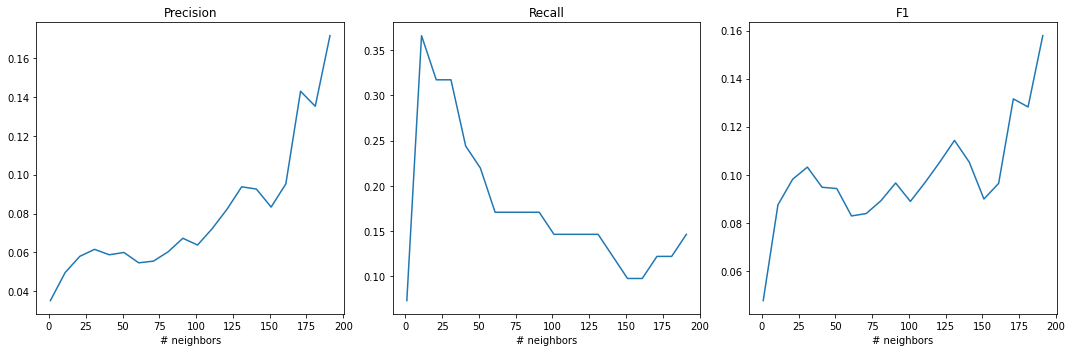

In [ ]:
n_neighbors_range = np.arange(1, 201, 10)
precision_range = np.zeros(n_neighbors_range.size)
recall_range = np.zeros(n_neighbors_range.size)
f1_range = np.zeros(n_neighbors_range.size)

for i in range(n_neighbors_range.size):
  knn = KNeighborsClassifier(n_neighbors=n_neighbors_range[i], weights='uniform')
  knn.fit(X_train_resample, y_train_resample)
  y_cv_pred = knn.predict(X_cv)
  precision_range[i] = precision_score(y_cv, y_cv_pred)
  recall_range[i] = recall_score(y_cv, y_cv_pred)
  f1_range[i] = f1_score(y_cv, y_cv_pred)

max_precision_id = np.argmax(precision_range)
max_recall_id = np.argmax(recall_range)
max_f1_id = np.argmax(f1_range)
print("Max precision is %.4f with %d neighbors" % (precision_range[max_precision_id], n_neighbors_range[max_precision_id]))
print("Max recall is %.4f with %d neighbors" % (recall_range[max_recall_id], n_neighbors_range[max_recall_id]))
print("Max F1 is %.4f with %d neighbors" % (f1_range[max_f1_id], n_neighbors_range[max_f1_id]))
best_knn_neighbor = n_neighbors_range[max_f1_id]

fig, axs = plt.subplots(1, 3,figsize=(15,5))
axs[0].plot(n_neighbors_range, precision_range)
axs[0].set_title("Precision")
axs[0].set_xlabel("# neighbors")
axs[1].plot(n_neighbors_range, recall_range)
axs[1].set_title("Recall")
axs[1].set_xlabel("# neighbors")
axs[2].plot(n_neighbors_range, f1_range)
axs[2].set_title("F1")
axs[2].set_xlabel("# neighbors")
plt.tight_layout()
plt.show()

**Best knn model has the following hyperparameters:**

- 191 neighbours

## Decision Tree

Max precision is 0.0519 with max depth of 10
Max recall is 0.7561 with max depth of 4
Max F1 is 0.0934 with max depth of 10


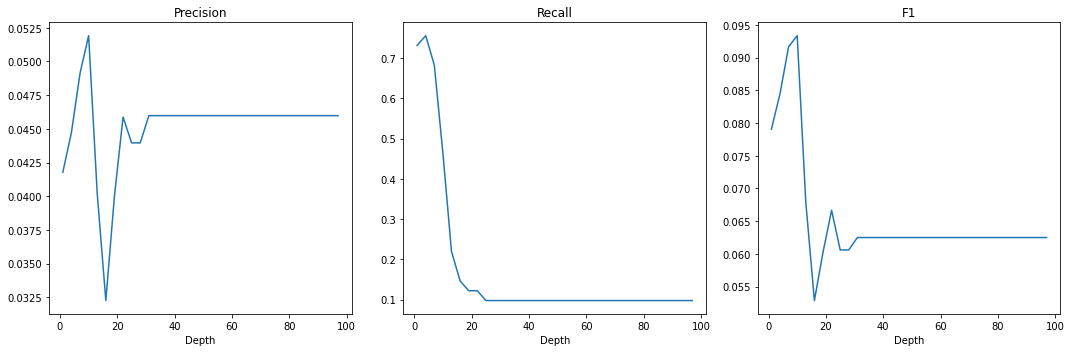

In [ ]:
depth_range = np.arange(1, 100, 3)
precision_range = np.zeros(depth_range.size)
recall_range = np.zeros(depth_range.size)
f1_range = np.zeros(depth_range.size)

for i in range(depth_range.size):
  dec_tree = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',max_depth=depth_range[i], random_state=0)
  dec_tree.fit(X_train_resample, y_train_resample)
  y_cv_pred = dec_tree.predict(X_cv)
  precision_range[i] = precision_score(y_cv, y_cv_pred)
  recall_range[i] = recall_score(y_cv, y_cv_pred)
  f1_range[i] = f1_score(y_cv, y_cv_pred)

max_precision_id = np.argmax(precision_range)
max_recall_id = np.argmax(recall_range)
max_f1_id = np.argmax(f1_range)
print("Max precision is %.4f with max depth of %d" % (precision_range[max_precision_id], depth_range[max_precision_id]))
print("Max recall is %.4f with max depth of %d" % (recall_range[max_recall_id], depth_range[max_recall_id]))
print("Max F1 is %.4f with max depth of %d" % (f1_range[max_f1_id], depth_range[max_f1_id]))
best_dec_tree_depth = depth_range[max_f1_id]

fig, axs = plt.subplots(1, 3,figsize=(15,5))
axs[0].plot(depth_range, precision_range)
axs[0].set_title("Precision")
axs[0].set_xlabel("Depth")
axs[1].plot(depth_range, recall_range)
axs[1].set_title("Recall")
axs[1].set_xlabel("Depth")
axs[2].plot(depth_range, f1_range)
axs[2].set_title("F1")
axs[2].set_xlabel("Depth")
plt.tight_layout()
plt.show()

**Best decision tree model has the following hyperparameters:**

- max_depth=10

## Random forest

Max precision is 0.0833 with 60 estimators and max depth of 41
Max recall is 0.8049 with 60 estimators and max depth of 1
Max F1 is 0.0900 with 160 estimators and max depth of 1


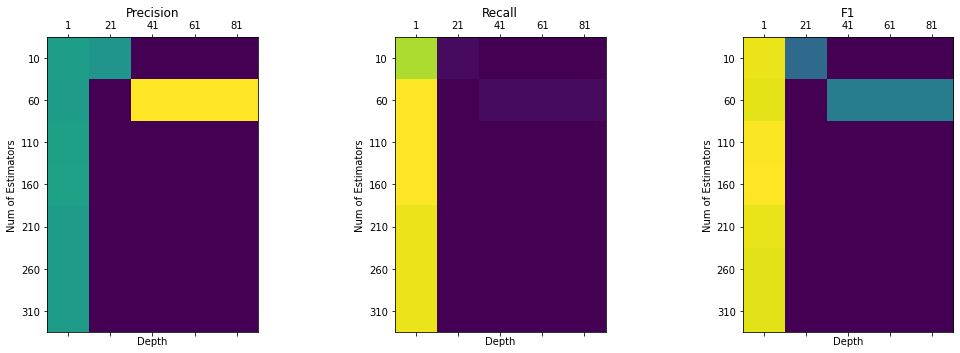

In [ ]:
n_est_range = np.arange(10, 311, 50)
depth_range = np.arange(1, 101, 20)

precision_range = np.zeros((n_est_range.size, depth_range.size))
recall_range = np.zeros((n_est_range.size, depth_range.size))
f1_range = np.zeros((n_est_range.size, depth_range.size)) 

for i in range(n_est_range.size):
  for j in range(depth_range.size):
    forest = RandomForestClassifier(n_estimators=n_est_range[i], max_depth=depth_range[j], class_weight='balanced',random_state=0)
    forest.fit(X_train_resample, y_train_resample)
    y_cv_pred = forest.predict(X_cv)
    precision_range[i, j] = precision_score(y_cv, y_cv_pred)
    recall_range[i, j] = recall_score(y_cv, y_cv_pred)
    f1_range[i, j] = f1_score(y_cv, y_cv_pred)

max_precision_id = np.argwhere(precision_range==precision_range.max())
max_recall_id = np.argwhere(recall_range==recall_range.max())
max_f1_id = np.argwhere(f1_range==f1_range.max())
print("Max precision is %.4f with %d estimators and max depth of %d" % (precision_range[max_precision_id[0, 0], max_precision_id[0, 1]], n_est_range[max_precision_id[0, 0]], depth_range[max_precision_id[0, 1]]))
print("Max recall is %.4f with %d estimators and max depth of %d" % (recall_range[max_recall_id[0, 0], max_recall_id[0, 1]], n_est_range[max_recall_id[0, 0]], depth_range[max_recall_id[0, 1]]))
print("Max F1 is %.4f with %d estimators and max depth of %d" % (f1_range[max_f1_id[0, 0], max_f1_id[0, 1]], n_est_range[max_f1_id[0, 0]], depth_range[max_f1_id[0, 1]]))
best_forest_n_est = n_est_range[max_f1_id[0, 0]]
best_forest_depth = depth_range[max_f1_id[0, 1]]

fig, axs = plt.subplots(1, 3,figsize=(15,5))
axs[0].matshow(precision_range)
axs[0].set_yticks(range(n_est_range.size))
axs[0].set_xticks(range(depth_range.size))
axs[0].set_yticklabels(list(n_est_range))
axs[0].set_xticklabels(list(depth_range))
axs[0].set_ylabel("Num of Estimators")
axs[0].set_xlabel("Depth")
axs[0].set_title("Precision")
axs[1].matshow(recall_range)
axs[1].set_yticks(range(n_est_range.size))
axs[1].set_xticks(range(depth_range.size))
axs[1].set_yticklabels(list(n_est_range))
axs[1].set_xticklabels(list(depth_range))
axs[1].set_ylabel("Num of Estimators")
axs[1].set_xlabel("Depth")
axs[1].set_title("Recall")
axs[2].matshow(f1_range)
axs[2].set_yticks(range(n_est_range.size))
axs[2].set_xticks(range(depth_range.size))
axs[2].set_yticklabels(list(n_est_range))
axs[2].set_xticklabels(list(depth_range))
axs[2].set_ylabel("Num of Estimators")
axs[2].set_xlabel("Depth")
axs[2].set_title("F1")
plt.tight_layout()
plt.show()

**Best random forest model has the following hyperparameters:**

- max_depth=1 and number of estimators=160

## SVM

Max precision is 0.0531 with max C of 1
Max recall is 0.6585 with max C of 1
Max F1 is 0.0984 with max C of 1


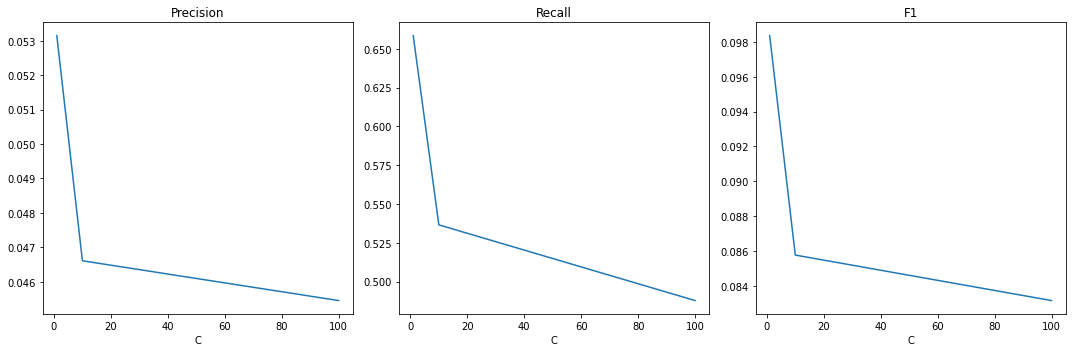

In [ ]:
c_range = [1.0, 10.0, 100.0]

precision_range = np.zeros((len(c_range)))
recall_range = np.zeros((len(c_range)))
f1_range = np.zeros((len(c_range)))

for i in range(len(c_range)):
  svm = SVC(C=c_range[i], kernel='poly', class_weight='balanced', random_state=0)  # maybe set class_weight to "balanced"
  svm.fit(X_train_resample, y_train_resample)
  y_cv_pred = svm.predict(X_cv)
  precision_range[i] = precision_score(y_cv, y_cv_pred)
  recall_range[i] = recall_score(y_cv, y_cv_pred)
  f1_range[i] = f1_score(y_cv, y_cv_pred)

max_precision_id = np.argmax(precision_range)
max_recall_id = np.argmax(recall_range)
max_f1_id = np.argmax(f1_range)
print("Max precision is %.4f with max C of %d" % (precision_range[max_precision_id], c_range[max_precision_id]))
print("Max recall is %.4f with max C of %d" % (recall_range[max_recall_id], c_range[max_recall_id]))
print("Max F1 is %.4f with max C of %d" % (f1_range[max_f1_id], c_range[max_f1_id]))
best_C = c_range[max_f1_id]

fig, axs = plt.subplots(1, 3,figsize=(15,5))
axs[0].plot(c_range, precision_range)
axs[0].set_title("Precision")
axs[0].set_xlabel("C")
axs[1].plot(c_range, recall_range)
axs[1].set_title("Recall")
axs[1].set_xlabel("C")
axs[2].plot(c_range, f1_range)
axs[2].set_title("F1")
axs[2].set_xlabel("C")
plt.tight_layout()
plt.show()

**Best SVM model has the following hyperparameters:**

- C= 1
- kernel =poly

## Ensemble Model: AdaBoost

Max precision is 0.2000 with 91 estimators and learning rate of 0.19
Max recall is 0.4634 with 1 estimators and learning rate of 0.01
Max F1 is 0.0936 with 1 estimators and learning rate of 0.01
The best number of estimators is 1 and best learning rate is 0.01


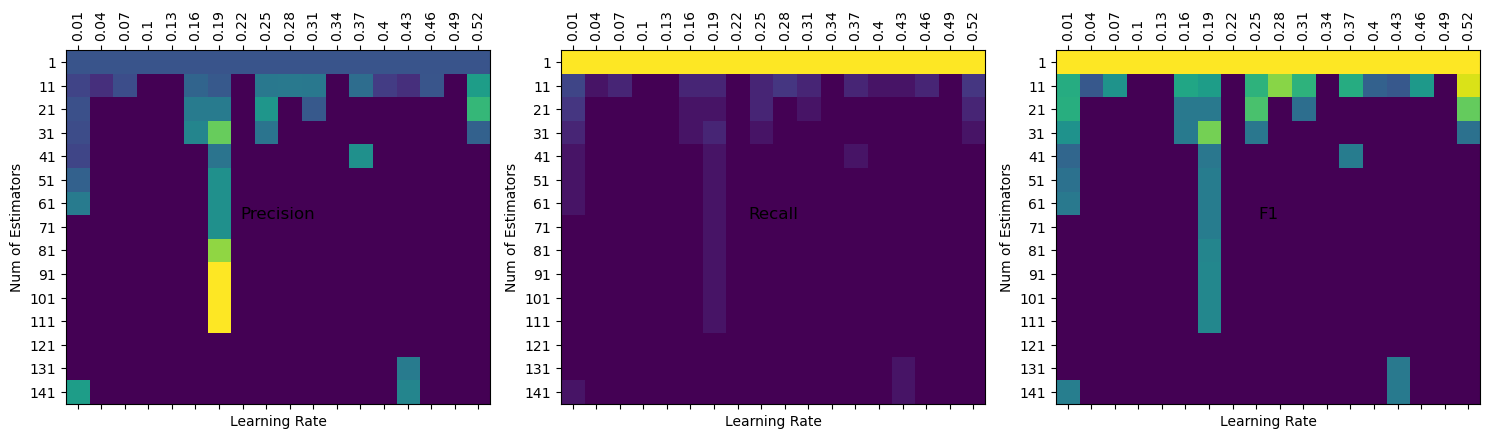

In [ ]:
n_est_range = np.arange(1, 151, 10)
lr_range = np.arange(0.01, 0.53, 0.03)

precision_range = np.zeros((n_est_range.size, lr_range.size))
recall_range = np.zeros((n_est_range.size, lr_range.size))
f1_range = np.zeros((n_est_range.size, lr_range.size)) 
estimator=RandomForestClassifier(n_estimators=160, max_depth=1, class_weight='balanced',random_state=0)
for i in range(n_est_range.size):
  for j in range(lr_range.size):
    ada = AdaBoostClassifier(base_estimator=estimator,n_estimators=n_est_range[i], learning_rate=lr_range[j], random_state=0)
    ada.fit(X_train_resample, y_train_resample)
    y_cv_pred = ada.predict(X_cv)
    precision_range[i, j] = precision_score(y_cv, y_cv_pred)
    recall_range[i, j] = recall_score(y_cv, y_cv_pred)
    f1_range[i, j] = f1_score(y_cv, y_cv_pred)

max_precision_id = np.argwhere(precision_range==precision_range.max())
max_recall_id = np.argwhere(recall_range==recall_range.max())
max_f1_id = np.argwhere(f1_range==f1_range.max())
print("Max precision is %.4f with %d estimators and learning rate of %.2f" % (precision_range[max_precision_id[0, 0], max_precision_id[0, 1]], n_est_range[max_precision_id[0, 0]], lr_range[max_precision_id[0, 1]]))
print("Max recall is %.4f with %d estimators and learning rate of %.2f" % (recall_range[max_recall_id[0, 0], max_recall_id[0, 1]], n_est_range[max_recall_id[0, 0]], lr_range[max_recall_id[0, 1]]))
print("Max F1 is %.4f with %d estimators and learning rate of %.2f" % (f1_range[max_f1_id[0, 0], max_f1_id[0, 1]], n_est_range[max_f1_id[0, 0]], lr_range[max_f1_id[0, 1]]))
best_ada_n_est = n_est_range[max_f1_id[0, 0]]
best_ada_lr = lr_range[max_f1_id[0, 1]]

print('The best number of estimators is',best_ada_n_est,'and best learning rate is',best_ada_lr)

fig, axs = plt.subplots(1, 3,figsize=(15,5))
axs[0].matshow(precision_range)
axs[0].set_yticks(range(n_est_range.size))
axs[0].set_xticks(range(lr_range.size))
axs[0].set_yticklabels(list(n_est_range))
axs[0].set_xticklabels([round(lr,3) for lr in lr_range],rotation=90)
axs[0].set_ylabel("Num of Estimators")
axs[0].set_xlabel("Learning Rate")
axs[0].set_title("Precision", y=0.5)
axs[1].matshow(recall_range)
axs[1].set_yticks(range(n_est_range.size))
axs[1].set_xticks(range(lr_range.size))
axs[1].set_yticklabels(list(n_est_range))
axs[1].set_xticklabels([round(lr,3) for lr in lr_range],rotation=90)
axs[1].set_ylabel("Num of Estimators")
axs[1].set_xlabel("Learning Rate")
axs[1].set_title("Recall", y=0.5)
axs[2].matshow(f1_range)
axs[2].set_yticks(range(n_est_range.size))
axs[2].set_xticks(range(lr_range.size))
axs[2].set_yticklabels(list(n_est_range))
axs[2].set_xticklabels([round(lr,3) for lr in lr_range],rotation=90)
axs[2].set_ylabel("Num of Estimators")
axs[2].set_xlabel("Learning Rate")
axs[2].set_title("F1", y=0.5)
plt.tight_layout()
plt.show()

**Best adaboost model has the following hyperparameters:**

- Number of estimators=1
- Learning rate=0.01

## Ensemble Model: Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

#using the best random forest from above
estimator=RandomForestClassifier(n_estimators=160, max_depth=1, class_weight='balanced',random_state=0)
bagging_model = BaggingClassifier(base_estimator=estimator,n_jobs=-1)
bagging_model.fit(X_train_resample, y_train_resample)
y_train_pred_bagging= bagging_model.predict(X_train_resample)
y_val_pred_bagging = bagging_model.predict(X_cv)
y_test_pred_bagging = bagging_model.predict(X_test)

## Neural Network Model: Multi-layer Perceptron Classifier

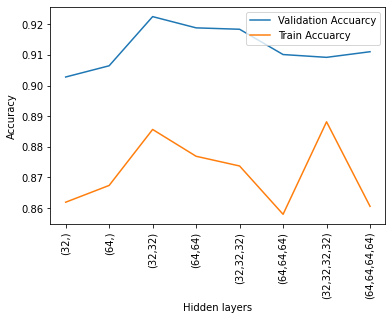

The best number of hidden layers/size: (32, 32) and corresponding validation accuracy: 92.251 %


In [ ]:
best_acc=0
acc_list=[]
acc_list_train=[]
range_of_parameter=[(32,),(64,),(32,32),(64,64),(32,32,32),(64,64,64),(32,32,32,32),(64,64,64,64)]
for hidden in range_of_parameter:
  #Fitting the deep learning model with adam optimizer, and an output sigmoid layer
  DLmodel=MLPClassifier(hidden_layer_sizes=hidden,\
                          alpha=0.02,\
                          activation='tanh',\
                        solver='lbfgs',
                          random_state=1)
  #Fitting the model on train data
  DLmodel.fit(X_train_resample, y_train_resample)

  #Checking validation accuracy for each set of hyperparameters
  DL_pred=DLmodel.predict(X_cv)
  DL_pred_train=DLmodel.predict(X_train_resample)

  #calculating val accuracy
  accuracy=accuracy_score(y_cv,DL_pred)
  acc_list.append(accuracy)

  #calculating train accuracy
  acc_train=accuracy_score(y_train_resample,DL_pred_train)
  acc_list_train.append(acc_train)
  
  #Getting the best hyperparameter
  if accuracy > best_acc:
    best_acc=accuracy
    best_parameter=hidden
   
#Plotting accuracy vs the hyperparameter to check overfitting:
labels=['(32,)','(64,)','(32,32)','(64,64)','(32,32,32)','(64,64,64)',\
        '(32,32,32,32)','(64,64,64,64)']
plt.plot(labels,acc_list,label='Validation Accuarcy')
plt.plot(labels,acc_list_train,label='Train Accuarcy')
plt.xlabel('Hidden layers')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#print the best hyperaparameters and corresponding validation accuracy
print('The best number of hidden layers/size:',best_parameter,'and corresponding validation accuracy:',round(float(best_acc*100),3),'%')

# Getting the validation and test predictions of the best ML models:



In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=191, weights='uniform')
best_dec_tree = DecisionTreeClassifier(criterion="entropy", class_weight='balanced',max_depth=10, random_state=0)
best_forest = RandomForestClassifier(n_estimators=160, max_depth=1, class_weight='balanced',random_state=0)
best_svm = SVC(C=1, kernel='poly', class_weight='balanced', random_state=0) 

#getting the best random forest model from above for base estimator
ada_estimator=RandomForestClassifier(n_estimators=160, max_depth=1, class_weight='balanced',random_state=0)
best_ada = AdaBoostClassifier(base_estimator=ada_estimator,n_estimators=1, learning_rate=0.01, random_state=0)
best_mlp= MLPClassifier(hidden_layer_sizes=(32,32),alpha=0.02,activation='tanh',solver='lbfgs',random_state=1)

# training
best_knn.fit(X_train_resample, y_train_resample)
best_dec_tree.fit(X_train_resample, y_train_resample)
best_forest.fit(X_train_resample, y_train_resample)
best_svm.fit(X_train_resample, y_train_resample)
best_ada.fit(X_train_resample, y_train_resample)
best_mlp.fit(X_train_resample, y_train_resample)

# results on the train set
y_train_pred_knn = best_knn.predict(X_train_resample)
y_train_pred_dec_tree = best_dec_tree.predict(X_train_resample)
y_train_pred_forest = best_forest.predict(X_train_resample)
y_train_pred_svm = best_svm.predict(X_train_resample)
y_train_pred_ada = best_ada.predict(X_train_resample)
y_train_pred_mlp = best_mlp.predict(X_train_resample)

# results on validation set
y_val_pred_knn = best_knn.predict(X_cv)
y_val_pred_dec_tree = best_dec_tree.predict(X_cv)
y_val_pred_forest = best_forest.predict(X_cv)
y_val_pred_svm = best_svm.predict(X_cv)
y_val_pred_ada = best_ada.predict(X_cv)
y_val_pred_mlp = best_mlp.predict(X_cv)

# results on the test set
y_test_pred_knn = best_knn.predict(X_test)
y_test_pred_dec_tree = best_dec_tree.predict(X_test)
y_test_pred_forest = best_forest.predict(X_test)
y_test_pred_svm = best_svm.predict(X_test)
y_test_pred_ada = best_ada.predict(X_test)
y_test_pred_mlp = best_mlp.predict(X_test)

# Autoencoder

Below we use autoencoder in order to explore how we can tackle the heavy imbalance of classes in the dataset.

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
import torch
import time

from imblearn.over_sampling import SMOTE

In [ ]:
X_train_false = X_train_resample.values[np.where(y_train_resample.values==0)[0]]
y_train_false = y_train_resample.values[np.where(y_train_resample.values==0)[0]]

X_train_true = X_train_resample.values[np.where(y_train_resample.values==1)[0]]
y_train_true = y_train_resample.values[np.where(y_train_resample.values==1)[0]]

X_cv_false = X_cv.values[np.where(y_cv.values==0)[0]]
y_cv_false = y_cv.values[np.where(y_cv.values==0)[0]]

X_cv_true = X_cv.values[np.where(y_cv.values==1)[0]]
y_cv_true = y_cv.values[np.where(y_cv.values==1)[0]]

X_test_false = X_test.values[np.where(y_test.values==0)[0]]
y_test_false = y_test.values[np.where(y_test.values==0)[0]]

X_test_true = X_test.values[np.where(y_test.values==1)[0]]
y_test_true = y_test.values[np.where(y_test.values==1)[0]]

In [ ]:
class data_set(Dataset):
    def __init__(self, X):
        self.X = X
        #self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index]#, self.Y[index],

In [ ]:
use_cuda = True

def func_accuracy(model, loader, criterion):
    # Function to calculate accuracy of the classification model

    correct = 0
    total = 0
    total_loss = 0
    i = 0
    
    model.eval()
    for X in loader:
        X = X.float()
        
        
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            X = X.cuda()
            
        
        output = model(X)
        
        loss = criterion(output, X)
        total_loss += loss.item()
        i+=1
        
    loss = float(total_loss) / (i)
    
    return loss


def func_get_name(name, batch_size, learning_rate, epoch):
    # Function to generate path for saving the model
    path = "model_{0}_bs{1}_lr{2}_epoch{3}.pt".format(name,
                                                      batch_size,
                                                      learning_rate,
                                                      epoch)
    
    return path


def func_plot_training_curve(path): 
    # Function to generate the plots for the respective training iteration
    
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    n = len(train_loss)
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def func_train_my(model, train_loader, val_loader, name, criterion, batch_size=64, learning_rate=0.01, num_epochs=30):
    # function is created for custom calling the training function of passed model
 
    # Using an Adam Optimizer with lr = 0.1
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr = 1e-1,
                                 weight_decay = 1e-8)
  
    train_loss, val_loss = [], []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        
            total_train_loss=0
            batch_num=0
            model.train()

            for imgs in iter(train_loader):
                imgs = imgs.float()
                
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                    imgs = imgs.cuda()
                    
      
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward Pass
                
                out = model(imgs)                   
                # Compute Loss
                loss = criterion(out, imgs)
                # Backward Propagation
                loss.backward()               
                #Parameter Updates
                optimizer.step() 
                batch_num+=1 
                
               
                # save the current training information
                #total_train_loss += loss.item()
      
            #Save Loss and accuracy
            #train_loss.append(float(total_train_loss) / (batch_num))
            
            with torch.no_grad():
                val_ls = func_accuracy(model, loader=val_loader, criterion=criterion)
                tr_ls = func_accuracy(model, loader=train_loader, criterion=criterion)
                
            
            val_loss.append(val_ls)
            train_loss.append(tr_ls)
            
            print(("Epoch {}: Train loss: {} |"+
                   "Validation loss: {}").format(epoch+1,
                                                 train_loss[epoch],
                                                 val_loss[epoch]))
    
            # Save the model(checkpoint) to a file in google drive
            model_path = func_get_name(name, batch_size, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("The trajectory of the training/validation error and loss:")
    print("--------------------------------------------------------------------------")
    func_plot_training_curve(model_path)

In [ ]:
class AE_1(torch.nn.Module):
    def __init__(self, k):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(k, int(k/2)),
            torch.nn.BatchNorm1d(int(k/2)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(k/2), 4),
            torch.nn.BatchNorm1d(4),
            torch.nn.ReLU()
        )
         
        self.decoder = torch.nn.Sequential(
            
            torch.nn.Linear(4, int(k/2)),
            torch.nn.BatchNorm1d(int(k/2)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(k/2), k),
            torch.nn.BatchNorm1d(k),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x.float())
        decoded = self.decoder(encoded)
        return decoded



In [ ]:
train_datasets = data_set(X_train_false)
val_datasets = data_set(X_cv_false)
test_datasets = data_set(X_test_false)

train_true_datasets = data_set(X_train_true)
val_true_datasets = data_set(X_cv_true)
test_true_datasets = data_set(X_test_true)

In [ ]:
batch_ = 128
train_loader = torch.utils.data.DataLoader(dataset = train_datasets,
                                           batch_size = batch_,
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(dataset = val_datasets,
                                           batch_size = 2*batch_,
                                           shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                           batch_size = 2*batch_,
                                           shuffle = False)

In [ ]:
model = AE_1(np.shape(X_train)[1])  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model

AE_1(
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=7, bias=True)
    (1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=7, out_features=4, bias=True)
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=7, bias=True)
    (1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=7, out_features=15, bias=True)
    (4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
  )
)

Epoch 1: Train loss: 0.06721134241374713 |Validation loss: 0.06632757973339823
Epoch 2: Train loss: 0.030348665775760772 |Validation loss: 0.02958906504015128
Epoch 3: Train loss: 0.024656741924229123 |Validation loss: 0.024096418172121048
Epoch 4: Train loss: 0.016582156782822002 |Validation loss: 0.015616681323283248
Epoch 5: Train loss: 0.016502355801917258 |Validation loss: 0.015219442856808504
Epoch 6: Train loss: 0.014977075795214328 |Validation loss: 0.013729004913734065
Epoch 7: Train loss: 0.015081236538078104 |Validation loss: 0.013653921687768565
Epoch 8: Train loss: 0.01315451380870645 |Validation loss: 0.012194057512614462
Epoch 9: Train loss: 0.014442612431825154 |Validation loss: 0.013843444279498525
Epoch 10: Train loss: 0.0122458069836573 |Validation loss: 0.010917739942669868
Epoch 11: Train loss: 0.01503471505369932 |Validation loss: 0.014002830307516787
Epoch 12: Train loss: 0.010300757895622934 |Validation loss: 0.008996963397496276
Epoch 13: Train loss: 0.01504503

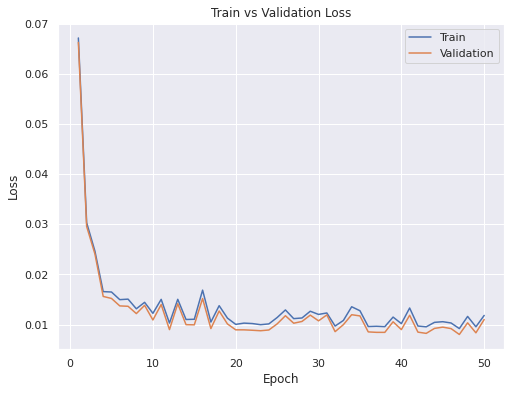

In [ ]:
lr=0.01
criterion = torch.nn.MSELoss()
func_train_my(model, train_loader, val_loader, name='AE_DNN_18drop', criterion=criterion, batch_size=batch_, learning_rate=lr, num_epochs=50)

In [ ]:
def func_accuracy_collect1(model, loader, criterion):
    # Function to calculate accuracy of the classification model

    loss_all = []
    model.eval()
    for X in loader:
        X = X.float()
        
        
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            X = X.cuda()
            
        output = model(X)
        
        loss = criterion(output, X)
        loss_all.append(loss.item())
            
    return loss_all

In [ ]:
criterion=torch.nn.MSELoss()
model2 = AE_1(np.shape(X_train)[1])  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)


model_path = func_get_name('AE_DNN_18drop', 128, 0.01, 48)
state = torch.load(model_path)
model2.load_state_dict(state)


<All keys matched successfully>

In [ ]:
##############################################################################
x_loader = torch.utils.data.DataLoader(dataset = train_datasets,
                                           batch_size = 1,
                                           shuffle = False)
with torch.no_grad():
    train_ls = func_accuracy_collect1(model2, loader=x_loader, criterion=criterion)

##############################################################################
x_loader = torch.utils.data.DataLoader(dataset = val_datasets,
                                           batch_size = 1,
                                           shuffle = False)
with torch.no_grad():
    val_ls = func_accuracy_collect1(model2, loader=x_loader, criterion=criterion)

##############################################################################
x_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                           batch_size = 1,
                                           shuffle = False)
with torch.no_grad():
    test_ls = func_accuracy_collect1(model2, loader=x_loader, criterion=criterion)

##############################################################################
x_loader = torch.utils.data.DataLoader(dataset = train_true_datasets,
                                           batch_size = 1,
                                           shuffle = False)
with torch.no_grad():
    train_t_ls = func_accuracy_collect1(model2, loader=x_loader, criterion=criterion)

##############################################################################
x_loader = torch.utils.data.DataLoader(dataset = val_true_datasets,
                                           batch_size = 1,
                                           shuffle = False)
with torch.no_grad():
    val_t_ls = func_accuracy_collect1(model2, loader=x_loader, criterion=criterion)

##############################################################################
x_loader = torch.utils.data.DataLoader(dataset = test_true_datasets,
                                           batch_size = 1,
                                           shuffle = False)
with torch.no_grad():
    test_t_ls = func_accuracy_collect1(model2, loader=x_loader, criterion=criterion)

##############################################################################


Text(0, 0.5, 'Reconstruction Error')

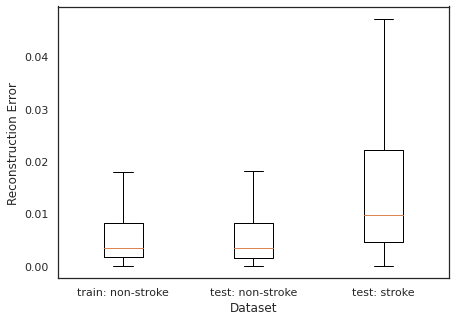

In [ ]:
plt.figure(figsize=(7,5))
sns.set(font_scale=1.0,style='white')
hist_t = plt.boxplot([np.array(train_ls), np.array(test_ls),
                      np.append(np.array(test_t_ls), np.array(train_t_ls))], showfliers=False)

plt.xticks([1, 2, 3], ['train: non-stroke', 'test: non-stroke',  'test: stroke']);
plt.xlabel('Dataset')
plt.ylabel('Reconstruction Error')
#plt.title('Reconstruction Error: MLP based AutoEncoder' );


In [ ]:

print("\n********TRAIN*****************")
train_ls_class = [1 if i>0.005 else 0 for i in train_ls]
train_ls_t_class = [1 if i>0.005 else 0 for i in train_t_ls]

tn = len(np.where(np.array(train_ls_class)==0)[0])
print("True Negative: ", tn)

fp = len(np.where(np.array(train_ls_class)==1)[0])
print("False Positive: ", fp)

fn = len(np.where(np.array(train_ls_t_class)==0)[0])
print("False Negative: ", fn)

tp = len(np.where(np.array(train_ls_t_class)==1)[0])
print("True Positive: ", tp)

print("Recall: ", (tp/(tp+fn)))
print("Precision: ", (tp/(tp+fp)))

print("\n********VAL*****************")
train_ls_class = [1 if i>0.005 else 0 for i in val_ls]
train_ls_t_class = [1 if i>0.005 else 0 for i in val_t_ls]

tn = len(np.where(np.array(train_ls_class)==0)[0])
print("True Negative: ", tn)

fp = len(np.where(np.array(train_ls_class)==1)[0])
print("False Positive: ", fp)

fn = len(np.where(np.array(train_ls_t_class)==0)[0])
print("False Negative: ", fn)

tp = len(np.where(np.array(train_ls_t_class)==1)[0])
print("True Positive: ", tp)

print("Recall: ", (tp/(tp+fn)))
print("Precision: ", (tp/(tp+fp)))


print("\n********TEST*****************")
train_ls_class = [1 if i>0.005 else 0 for i in test_ls]
train_ls_t_class = [1 if i>0.005 else 0 for i in test_t_ls]

tn = len(np.where(np.array(train_ls_class)==0)[0])
print("True Negative: ", tn)

fp = len(np.where(np.array(train_ls_class)==1)[0])
print("False Positive: ", fp)

fn = len(np.where(np.array(train_ls_t_class)==0)[0])
print("False Negative: ", fn)

tp = len(np.where(np.array(train_ls_t_class)==1)[0])
print("True Positive: ", tp)

print("Recall: ", (tp/(tp+fn)))
print("Precision: ", (tp/(tp+fp)))



********TRAIN*****************
True Negative:  5159
False Positive:  2841
False Negative:  730
True Positive:  1670
Recall:  0.6958333333333333
Precision:  0.3702061627133673

********VAL*****************
True Negative:  1405
False Positive:  735
False Negative:  15
True Positive:  26
Recall:  0.6341463414634146
Precision:  0.03416557161629435

********TEST*****************
True Negative:  4646
False Positive:  2485
False Negative:  45
True Positive:  92
Recall:  0.6715328467153284
Precision:  0.03570042685292976


# Evaluation metrics

### Train results

In [ ]:
accuracies=[]
precision=[]
recall=[]
f1=[]
balanced_accuracy=[]
auc_list=[]
train_predictions_list=[y_train_pred_knn,y_train_pred_dec_tree,y_train_pred_forest,y_train_pred_svm,y_train_pred_mlp,y_train_pred_ada,y_train_pred_bagging]
for pred in train_predictions_list:
  values=[]
  accuracies.append(round((accuracy_score(y_train_resample,pred)*100),2))
  precision.append(round(precision_score(y_train_resample,pred),3))
  recall.append(round(recall_score(y_train_resample,pred),3))
  f1.append(round(f1_score(y_train_resample,pred),3))
  balanced_accuracy.append(round((balanced_accuracy_score(y_train_resample,pred)*100),2))
  fpr, tpr, _ = roc_curve(y_train_resample, pred)
  auc_list.append(round(roc_auc_score(y_train_resample, pred), 4))

In [ ]:
#printing out the train results
indexes =  ['Balanced_Accuracy','Precision','Recall','F1Score','AUC']
models = ['KNN','Decision tree','Random forest', 'SVM','MLP','Adaboost','Bagging']

pre_df = pd.DataFrame(precision,index=models)
recall_df=pd.DataFrame(recall,index=models)
balaccuracy_df=pd.DataFrame(balanced_accuracy,index=models)
f1_df=pd.DataFrame(f1,index=models)
auc_df=pd.DataFrame(auc_list,index=models)

final_cla_df_train = pd.concat([balaccuracy_df,pre_df,recall_df,f1_df,auc_df],keys=indexes)
final_cla_train = final_cla_df_train.unstack()
final_cla_train=final_cla_train.droplevel(0, axis=1) 
final_cla_transposed_train = final_cla_train.T
final_cla_transposed_train

,Balanced_Accuracy,Precision,Recall,F1Score,AUC
KNN,55.35,0.667,0.126,0.212,0.5535
Decision tree,88.46,0.653,0.915,0.762,0.8846
Random forest,75.31,0.443,0.813,0.573,0.7531
SVM,80.03,0.525,0.825,0.641,0.8003
MLP,82.55,0.773,0.714,0.742,0.8255
Adaboost,75.39,0.444,0.814,0.574,0.7539
Bagging,75.32,0.441,0.818,0.573,0.7532


### Validation results

In [ ]:
accuracies=[]
precision=[]
recall=[]
f1=[]
balanced_accuracy=[]
auc_list=[]
val_predictions_list=[y_val_pred_knn,y_val_pred_dec_tree,y_val_pred_forest,y_val_pred_svm,y_val_pred_mlp,y_val_pred_ada,y_val_pred_bagging]
for pred in val_predictions_list:
  values=[]
  accuracies.append(round((accuracy_score(y_cv,pred)*100),2))
  precision.append(round(precision_score(y_cv,pred),3))
  recall.append(round(recall_score(y_cv,pred),3))
  f1.append(round(f1_score(y_cv,pred),3))
  balanced_accuracy.append(round((balanced_accuracy_score(y_cv,pred)*100),2))
  fpr, tpr, _ = roc_curve(y_cv, pred)
  auc_list.append(round(roc_auc_score(y_cv, pred), 4))

In [ ]:
#printing out the validation results
indexes =  ['Balanced_Accuracy','Precision','Recall','F1Score','AUC']
models = ['KNN','Decision tree','Random forest', 'SVM','MLP','Adaboost','Bagging']

pre_df = pd.DataFrame(precision,index=models)
recall_df=pd.DataFrame(recall,index=models)
balaccuracy_df=pd.DataFrame(balanced_accuracy,index=models)
f1_df=pd.DataFrame(f1,index=models)
auc_df=pd.DataFrame(auc_list,index=models)

final_cla_df_val = pd.concat([balaccuracy_df,pre_df,recall_df,f1_df,auc_df],keys=indexes)
final_cla_val = final_cla_df_val.unstack()
final_cla_val=final_cla_val.droplevel(0, axis=1) 
final_cla_transposed_val = final_cla_val.T
final_cla_transposed_val

,Balanced_Accuracy,Precision,Recall,F1Score,AUC
KNN,56.64,0.171,0.146,0.158,0.5664
Decision tree,65.06,0.052,0.463,0.093,0.6506
Random forest,74.85,0.048,0.805,0.090,0.7485
SVM,71.69,0.053,0.659,0.098,0.7169
MLP,56.58,0.056,0.195,0.086,0.5658
Adaboost,73.81,0.047,0.780,0.088,0.7381
Bagging,74.75,0.047,0.805,0.090,0.7475


### Test results

In [ ]:
accuracies=[]
precision=[]
recall=[]
f1=[]
balanced_accuracy=[]
auc_list=[]
test_predictions_list=[y_test_pred_knn,y_test_pred_dec_tree,y_test_pred_forest,y_test_pred_svm,y_test_pred_mlp,y_test_pred_ada,y_test_pred_bagging]
for pred in test_predictions_list:
  values=[]
  accuracies.append(round((accuracy_score(y_test,pred)*100),2))
  precision.append(round(precision_score(y_test,pred),3))
  recall.append(round(recall_score(y_test,pred),3))
  f1.append(round(f1_score(y_test,pred),3))
  balanced_accuracy.append(round((balanced_accuracy_score(y_test,pred)*100),2))
  fpr, tpr, _ = roc_curve(y_test, pred)
  auc_list.append(round(roc_auc_score(y_test, pred), 4))

In [ ]:
#printing out the test results
indexes =  ['Balanced_Accuracy','Precision','Recall','F1Score','AUC']
models = ['KNN','Decision tree','Random forest', 'SVM','MLP','Adaboost','Bagging']
acc_df = pd.DataFrame(accuracies,index=models)
pre_df = pd.DataFrame(precision,index=models)
recall_df=pd.DataFrame(recall,index=models)
balaccuracy_df=pd.DataFrame(balanced_accuracy,index=models)
auc_df=pd.DataFrame(auc_list,index=models)
f1_df=pd.DataFrame(f1,index=models)

final_cla_df_test = pd.concat([balaccuracy_df,pre_df,recall_df,f1_df,auc_df],keys=indexes)
final_cla_test = final_cla_df_test.unstack()
final_cla_test=final_cla_test.droplevel(0, axis=1) 
final_cla_transposed_test = final_cla_test.T
final_cla_transposed_test

,Balanced_Accuracy,Precision,Recall,F1Score,AUC
KNN,53.11,0.079,0.080,0.079,0.5311
Decision tree,66.09,0.055,0.482,0.098,0.6609
Random forest,74.33,0.047,0.796,0.089,0.7433
SVM,72.89,0.056,0.679,0.103,0.7289
MLP,56.46,0.050,0.204,0.080,0.5646
Adaboost,74.48,0.048,0.796,0.090,0.7448
Bagging,74.47,0.047,0.803,0.089,0.7447


## Plotting test ROC curve

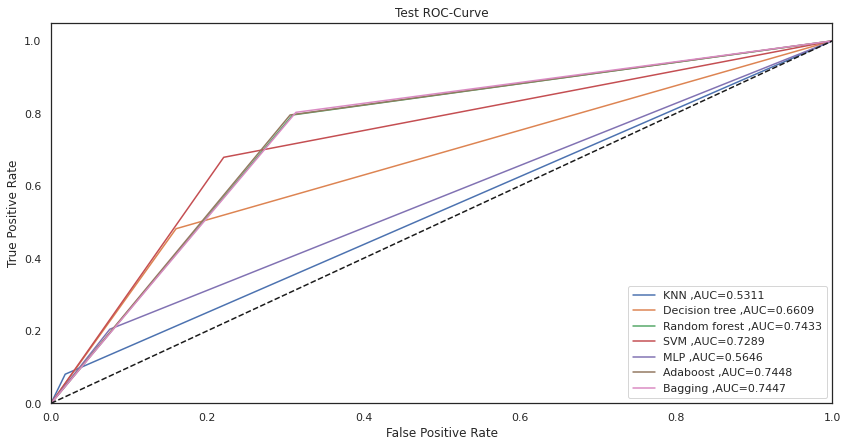

In [ ]:
auc_list=[]
plt.figure(figsize=(14,7))
sns.set(style='white')
for m in range(len(models)):
  fpr, tpr, _ = roc_curve(y_test, test_predictions_list[m])
  auc = round(roc_auc_score(y_test, test_predictions_list[m]), 4)
  auc_list.append(auc)
  plt.plot(fpr, tpr,label=models[m]+" ,AUC="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC-Curve')
plt.legend(loc="lower right")
plt.show()

## Plot a bar graph for the balanced accuracies, recall and AUC

In [ ]:
final_cla_transposed_acc_test=final_cla_transposed_test.iloc[:,:]
final_cla_transposed_acc_test['Train_Balanced_Accuracy']=final_cla_transposed_train['Balanced_Accuracy']
final_cla_transposed_acc_test['Validation_Balanced_Accuracy']=final_cla_transposed_val['Balanced_Accuracy']
final_cla_transposed_acc_test=final_cla_transposed_acc_test.sort_values(by='Balanced_Accuracy',ascending=False)

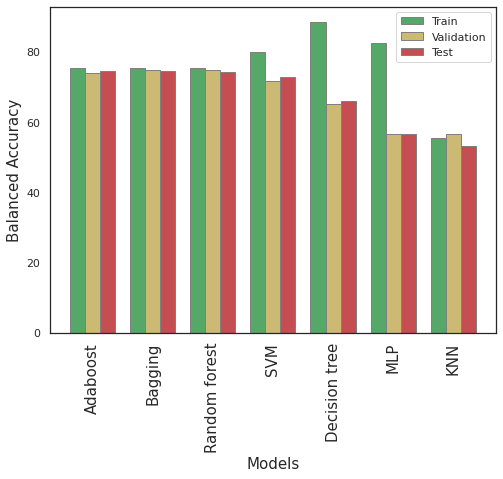

In [ ]:
#fig = plt.subplots(figsize =(8,6))

plt.figure(figsize=(8,6))
br1 = np.arange(len(final_cla_transposed_acc_test['Balanced_Accuracy'].values))
br2 = [x + 0.25 for x in br1]
br3 = [x + 0.5 for x in br1]
plt.bar(br1,final_cla_transposed_acc_test['Train_Balanced_Accuracy'].values, color ='g', width = 0.25,edgecolor ='grey', label ='Train')
plt.bar(br2,final_cla_transposed_acc_test['Validation_Balanced_Accuracy'].values, color ='y', width = 0.25,edgecolor ='grey', label ='Validation')
plt.bar(br3,final_cla_transposed_acc_test['Balanced_Accuracy'].values, color ='r', width = 0.25, edgecolor ='grey', label ='Test')
# Adding Xticks
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Balanced Accuracy', fontsize = 15)
plt.xticks([r + 0.25 for r in range(len(list(final_cla_transposed_acc_test.index)))],
        list(final_cla_transposed_acc_test.index),rotation=90,fontsize = 15)

plt.legend()
plt.show()

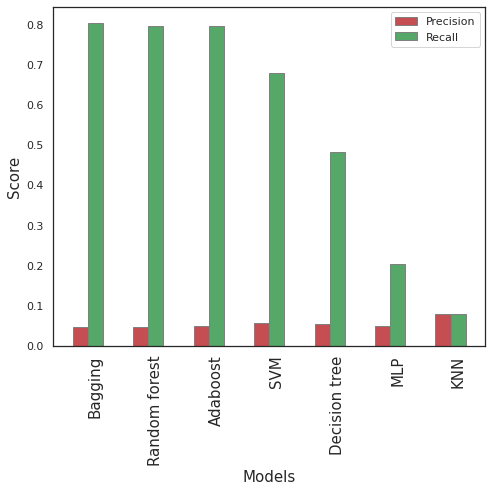

In [ ]:
final_cla_transposed_pre_rec=final_cla_transposed_test.sort_values(by='Recall',ascending=False)
plt.figure(figsize=(7,7))
br1 = np.arange(len(final_cla_transposed_pre_rec['Precision'].values))
br2 = [x + 0.25 for x in br1]
plt.bar(br1,final_cla_transposed_pre_rec['Precision'].values, color ='r', width = 0.25, edgecolor ='grey', label ='Precision')
plt.bar(br2,final_cla_transposed_pre_rec['Recall'].values, color ='g', width = 0.25,edgecolor ='grey', label ='Recall')
# Adding Xticks
plt.xlabel('Models',  fontsize = 15)
plt.ylabel('Score',  fontsize = 15)
plt.xticks([r + 0.25 for r in range(len(list(final_cla_transposed_pre_rec.index)))],
        list(final_cla_transposed_pre_rec.index),fontsize=15,rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

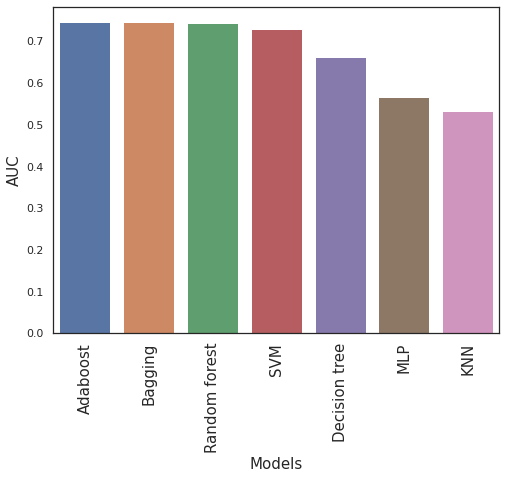

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(style='white')
final_cla_transposed_auc=final_cla_transposed_test.sort_values(by='AUC',ascending=False)
sns.barplot(x=final_cla_transposed_auc.index,y='AUC',data=final_cla_transposed_auc) 
plt.xticks(fontsize=15,rotation=90)
plt.xlabel('Models',  fontsize = 15)
plt.ylabel('AUC',  fontsize = 15)
plt.show()

## Plotting test confusion matrix for all models

Confusion Matrix for KNN


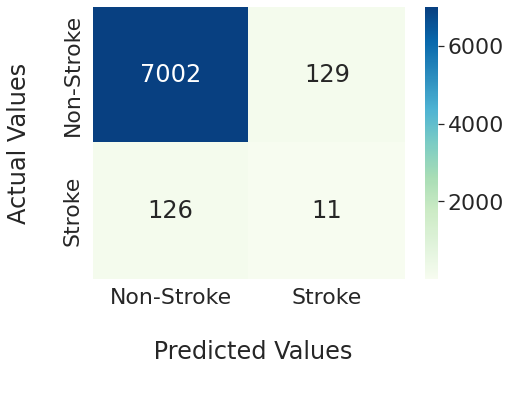

---------------------------------------------------------------------------
Confusion Matrix for Decision tree


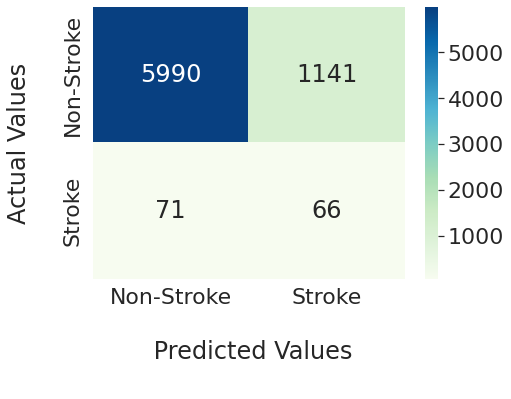

---------------------------------------------------------------------------
Confusion Matrix for Random forest


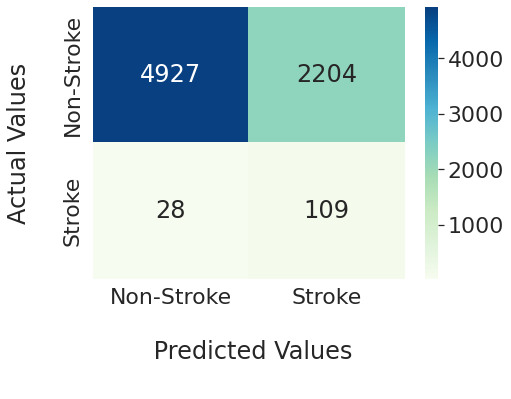

---------------------------------------------------------------------------
Confusion Matrix for SVM


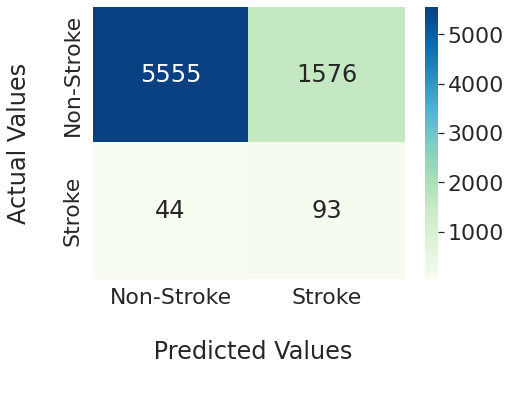

---------------------------------------------------------------------------
Confusion Matrix for MLP


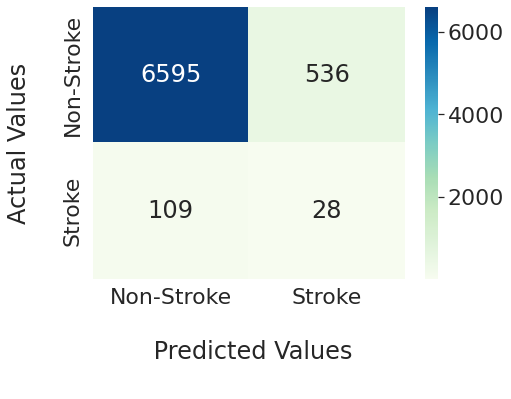

---------------------------------------------------------------------------
Confusion Matrix for Adaboost


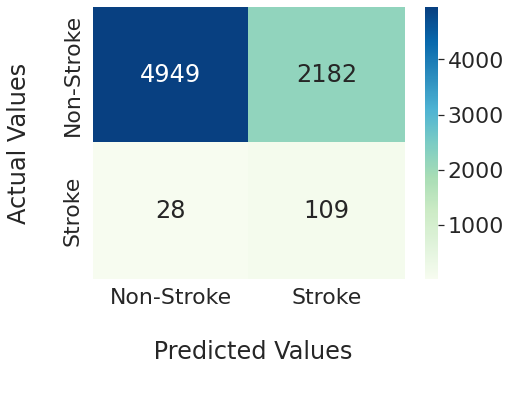

---------------------------------------------------------------------------
Confusion Matrix for Bagging


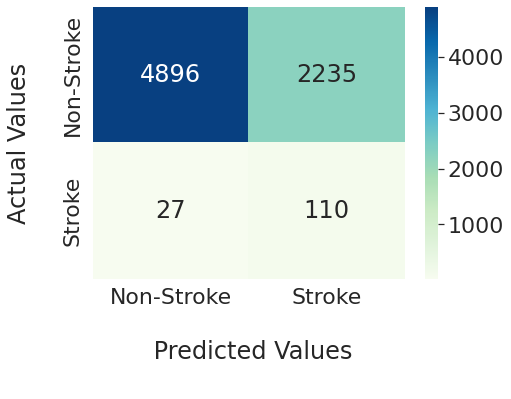

---------------------------------------------------------------------------


In [ ]:
for m in range(len(models)):
  print('Confusion Matrix for',models[m])
  plt.figure(figsize=(7,5))
  sns.set(font_scale=2.0)
  sns.heatmap(confusion_matrix(y_test,test_predictions_list[m]), xticklabels=['Non-Stroke','Stroke'],yticklabels=['Non-Stroke','Stroke'], annot=True, fmt=".0f",cmap="GnBu")
  plt.xlabel('\n Predicted Values\n')
  plt.ylabel('Actual Values\n');
  plt.show()
  print('-'*75)

# Performance of best models using original data 

In this part, we will comapre the performance of our models on original train dataset which was not resampled.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(n_jobs=-1)
bagging_model.fit(X_train, y_train)
y_train_pred_bagging_unsampled = bagging_model.predict(X_train)
y_val_pred_bagging_unsampled = bagging_model.predict(X_cv)
y_test_pred_bagging_unsampled = bagging_model.predict(X_test)

best_ada = AdaBoostClassifier(n_estimators=1, learning_rate=0.01, random_state=0)
best_ada.fit(X_train, y_train)
y_train_pred_ada_unsampled = best_ada.predict(X_train)
y_val_pred_ada_unsampled = best_ada.predict(X_cv)
y_test_pred_ada_unsampled = best_ada.predict(X_test)

accuracies=[]
precision=[]
recall=[]
f1=[]
balanced_accuracy=[]
auc_list=[]
test_predictions_list=[y_test_pred_bagging_unsampled,y_test_pred_ada_unsampled]
for pred in test_predictions_list:
  values=[]
  accuracies.append(round((accuracy_score(y_test,pred)*100),2))
  precision.append(round(precision_score(y_test,pred),3))
  recall.append(round(recall_score(y_test,pred),3))
  f1.append(round(f1_score(y_test,pred),3))
  balanced_accuracy.append(round((balanced_accuracy_score(y_test,pred)*100),2))
  auc_list.append(round(roc_auc_score(y_test, pred), 4))

models=['Bagging Classifier','Adaboost']
indexes =  ['Accuracy','Balanced_Accuracy','Precision','Recall','F1Score','AUC']
#printing out the test results
acc_df = pd.DataFrame(accuracies,index=models)
pre_df = pd.DataFrame(precision,index=models)
recall_df=pd.DataFrame(recall,index=models)
balaccuracy_df=pd.DataFrame(balanced_accuracy,index=models)
f1_df=pd.DataFrame(f1,index=models)
auc_df=pd.DataFrame(auc_list,index=models)

final_cla_df = pd.concat([acc_df,balaccuracy_df,pre_df,recall_df,f1_df,auc_df],keys=indexes)
final_cla = final_cla_df.unstack()
final_cla=final_cla.droplevel(0, axis=1) 
final_cla_transposed = final_cla.T
final_cla_transposed

,Accuracy,Balanced_Accuracy,Precision,Recall,F1Score,AUC
Bagging Classifier,97.98,50.29,0.083,0.007,0.013,0.5029
Adaboost,98.12,50.00,0.000,0.000,0.000,0.5000


Confusion Matrix for Bagging Classifier


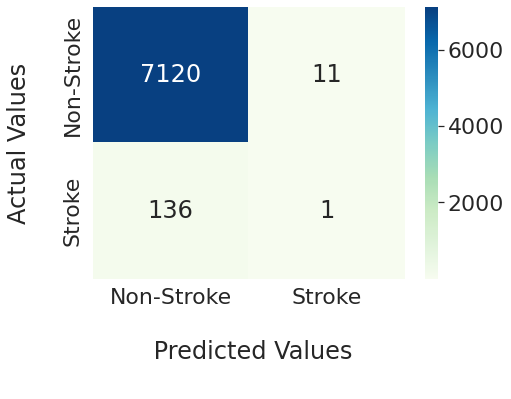

---------------------------------------------------------------------------
Confusion Matrix for Adaboost


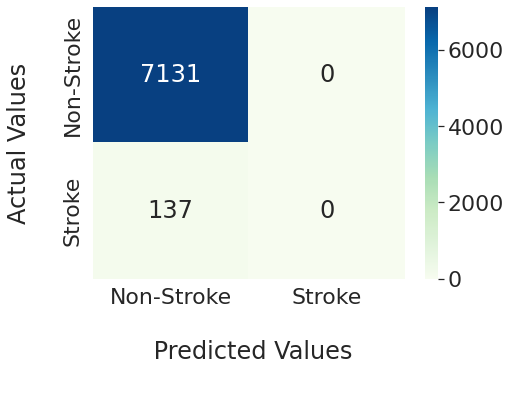

---------------------------------------------------------------------------


In [ ]:
for m in range(len(models)): 
  print('Confusion Matrix for',models[m])
  plt.figure(figsize=(7,5))
  sns.set(font_scale=2.0)
  sns.heatmap(confusion_matrix(y_test,test_predictions_list[m]), xticklabels=['Non-Stroke','Stroke'],yticklabels=['Non-Stroke','Stroke'], annot=True, fmt=".0f",cmap="GnBu")
  plt.xlabel('\n Predicted Values\n')
  plt.ylabel('Actual Values\n');
  plt.show()
  print('-'*75)

**The 0 true positives indicate that resampling the train data is extremely crucial for our problem.**

# Covariate shift

**Data drift using Jensen-Shannon divergence**

In [ ]:
from scipy.stats import gamma
from scipy.spatial import distance
#the data for which we need the divergence is X here
def features_drift(feature,base_X,target_X):

  #get the baseline distributions of the feature before Dec-13
  baseline_distribution=base_X[feature].values
  
  #get the bins for baseline distribution
  my_bins=np.linspace(min(baseline_distribution), max(baseline_distribution), 20)
  p=np.histogram(baseline_distribution, bins=np.r_[-np.inf, my_bins, np.inf])

  #create an empty list to store the js divergence of target distribution for each month after Jan-14
  jsval=[]
  
  #get the target distribution of the features for each month
  target_distribution=target_X[feature].values

  #use the bins of baseline distribution to get q 
  q=np.histogram(target_distribution, bins=np.r_[-np.inf, my_bins, np.inf])

  #calculate js divergence
  jsval.append(distance.jensenshannon(p[0],q[0], 2.0))
  return jsval,baseline_distribution,target_distribution,p,q

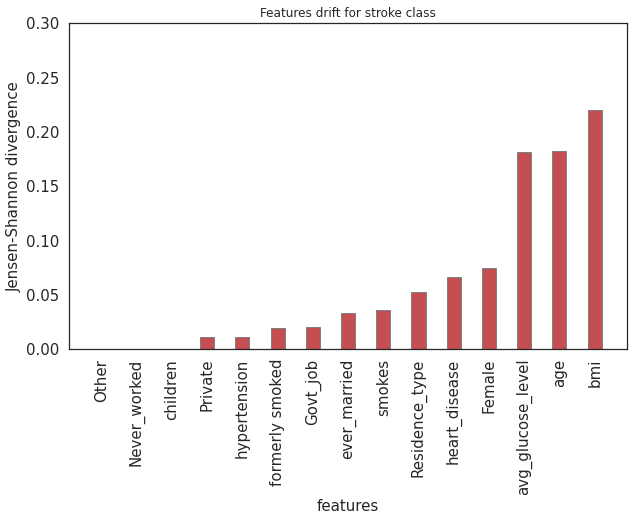

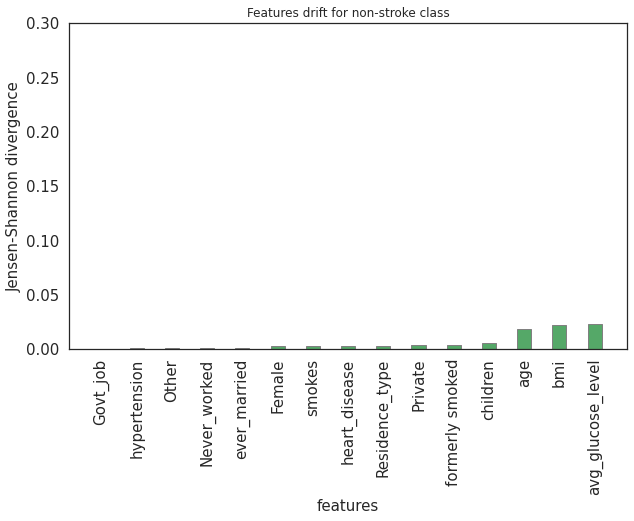

In [ ]:
#Drift of test set wrt trains set for stroke class 

X_train_drift=X_train.copy()
X_train_drift['stroke']= y_train.values
X_train_drift_pos=X_train_drift[X_train_drift['stroke']==1]
X_train_drift_pos=X_train_drift_pos.iloc[:,:-1]

X_train_drift_neg=X_train_drift[X_train_drift['stroke']==0]
X_train_drift_neg=X_train_drift_neg.iloc[:,:-1]


X_test_drift=X_test.copy()
X_test_drift['stroke']= y_test.values
X_test_drift_pos=X_test_drift[X_test_drift['stroke']==1]
X_test_drift_pos=X_test_drift_pos.iloc[:,:-1]

X_test_drift_neg=X_test_drift[X_test_drift['stroke']==0]
X_test_drift_neg=X_test_drift_neg.iloc[:,:-1]

sns.set(style='white')
jsvals=[]
for features in X_train_drift_pos.columns.tolist():
  jsvals.append(features_drift(features,X_train_drift_pos,X_test_drift_pos)[0][0])

df_divergence=pd.DataFrame({'Features':X_train.columns.tolist(), 'JS_Val':jsvals})
df_sorted_desc=df_divergence.sort_values('JS_Val')
plt.figure(figsize=(10,6))
plt.bar('Features', 'JS_Val',data=df_sorted_desc,color ='r', edgecolor ='grey',width = 0.4)
plt.xlabel("features",fontsize = 15)
plt.ylabel("Jensen-Shannon divergence",fontsize = 15)
plt.title('Features drift for stroke class')
plt.xticks(rotation=90,  fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim([0,0.30])
plt.show()

#Drift of test set wrt trains set for non-stroke class 
jsvals=[]
for features in X_train_drift_pos.columns.tolist():
  jsvals.append(features_drift(features,X_train_drift_neg,X_test_drift_neg)[0][0])

df_divergence=pd.DataFrame({'Features':X_train.columns.tolist(), 'JS_Val':jsvals})
df_sorted_desc=df_divergence.sort_values('JS_Val')
plt.figure(figsize=(10,6))
plt.bar('Features', 'JS_Val',data=df_sorted_desc,color ='g', edgecolor ='grey',width = 0.4)
plt.xlabel("features",fontsize = 15)
plt.ylabel("Jensen-Shannon divergence",fontsize = 15)
plt.title('Features drift for non-stroke class')
plt.xticks(rotation=90,  fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim([0,0.30])
plt.show()

# Interpreting model results

## SHAP(SHapley Additive exPlanations)

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def shap_plot(best_model,name): 
  median = X_train_resample.median().values.reshape((1,X_train_resample.shape[1]))
  explainer = shap.KernelExplainer(best_model.predict_proba, median)
  shap_values = explainer.shap_values(X_test)

  print('--------------------------------------')
  print('Shap plot for',name)
  print('--------------------------------------')

  shap.initjs()
  shap.summary_plot(shap_values[1], X_test, show=False)
  plt.show()

  0%|          | 0/7268 [00:00<?, ?it/s]

--------------------------------------
Shap plot for Bagging classifier
--------------------------------------


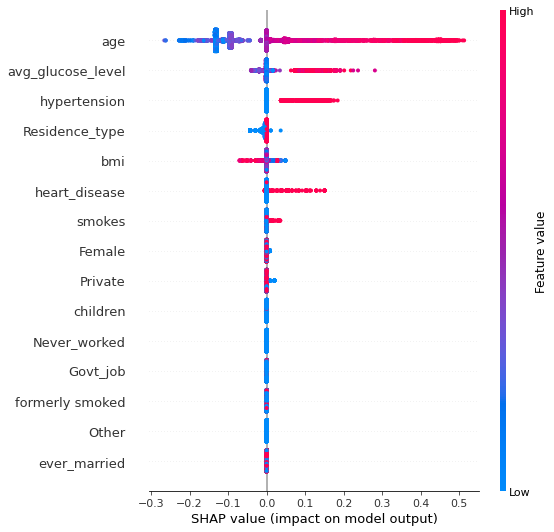

In [ ]:
shap_plot(bagging_model,'Bagging classifier')

## t-SNE visualizations for train set

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X_train_resample)

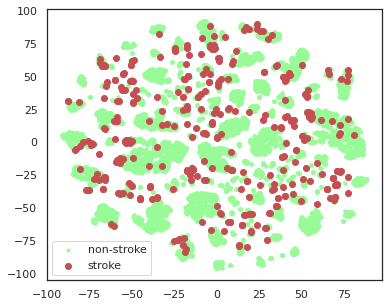

In [ ]:
target_ids = [0,1]

plt.figure(figsize=(6, 5))
colors = 'palegreen', 'r'
markers = '.', 'o'
for i, c, label,m in zip(target_ids, colors, ['non-stroke', 'stroke'],markers):
    plt.scatter(X_2d[y_train_resample == i, 0], X_2d[y_train_resample == i, 1], c=c, label=label,marker=m)
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=0)
X_3d = tsne.fit_transform(X_train_resample)


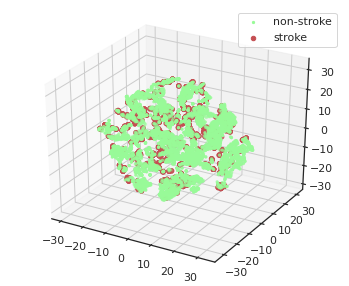

In [ ]:
target_ids = [0,1]

ax=plt.figure(figsize=(6, 5)).gca(projection='3d')
colors = 'palegreen', 'r'
markers = '.', 'o'
for i, c, label,m in zip(target_ids, colors, ['non-stroke', 'stroke'], markers):
    ax.scatter(X_3d[y_train_resample == i, 0], X_3d[y_train_resample == i, 1], X_3d[y_train_resample == i, 2] , 
               c=c, label=label, marker=m)
plt.legend()
plt.show()